In [1]:
import torch # Load the DINOv2 model 
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 48.6MB/s]


In [4]:
!pip install pytorch_lightning -q


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import torch
import torchvision
import pytorch_lightning as pl


class CustomCIFAR10Dataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

class CustomCIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, transform):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
        torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=self.transform)
            num_train = len(train_dataset)
            self.train_dataset, self.val_dataset = torch.utils.data.random_split(train_dataset, [num_train - 5000, 5000])

        if stage == 'test' or stage is None:
            self.test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=self.transform)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl


class LinearClassifierHead(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        return self.head(x)

In [8]:
class CustomModel(pl.LightningModule):
    def __init__(self, embed_dim, num_classes, learning_rate=0.001):
        super().__init__()
        self.dinov2_vits14 = dinov2_vits14.eval()
        self.linear_classifier_head = LinearClassifierHead(embed_dim, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.validation_losses = []

    def forward(self, x):
        with torch.no_grad():
            features = self.dinov2_vits14(x)
        return self.linear_classifier_head(features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.linear_classifier_head.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        val_images, val_labels = batch
        val_outputs = self(val_images)
        val_loss = self.criterion(val_outputs, val_labels)
        self.validation_losses.append(val_loss.item())
        return val_loss

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.log('val_loss', avg_val_loss, prog_bar=True)
        self.validation_losses = []

In [11]:
import time
# Configuration
batch_size = 1024
num_epochs = 2
learning_rate = 0.001
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_module = CustomCIFAR10DataModule(batch_size=batch_size, transform=transform)
model = CustomModel(embed_dim=dinov2_vits14.embed_dim, num_classes=10, learning_rate=learning_rate)
trainer = pl.Trainer(
    max_epochs=num_epochs,
    # val_check_interval=0.1,
    check_val_every_n_epoch=1,
    devices=1,
    )

# 시간 측정 시작
start_time = time.time()
trainer.fit(model, data_module)
trainer.validate(model, datamodule=data_module)
# 시간 측정 종료
end_time = time.time()

print(f"Training and testing complete. Total time: {end_time - start_time:.2f} seconds")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                  | Params | Mode 
-------------------------------------------------------------------------
0 | dinov2_vits14          | DinoVisionTransformer | 22.1 M | eval 
1 | linear_classifier_head | LinearClassifierHead  | 3.9 K  | train
2 | criterion              | CrossEntropyLoss      | 0      | train
-------------------------------------------------------------------------
22.1 M    Trainable params
0         Non-trainable params
22.1 M    Total params
88.242    Total estimated model params size (MB)
3         Modules in train mode
199       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 44/44 [01:16<00:00,  0.58it/s, v_num=0, val_loss=0.174]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 44/44 [01:16<00:00,  0.57it/s, v_num=0, val_loss=0.174]
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation DataLoader 0: 100%|██████████| 5/5 [00:09<00:00,  0.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     0.174236461520195     │
└───────────────────────────┴───────────────────────────┘

Training and testing complete. Total time: 184.48 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.352941..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2

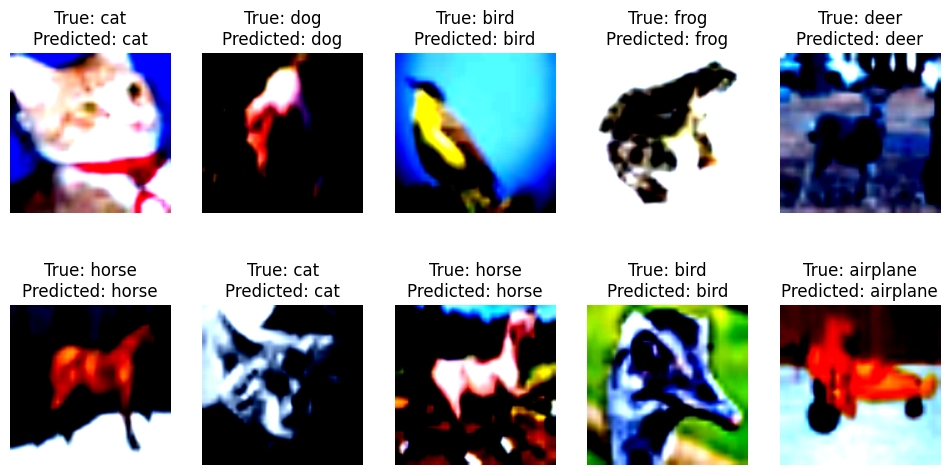

Accuracy on the validation dataset: 94.58%


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
# model = CustomModel(embed_dim=dinov2_vits14.embed_dim, num_classes=10, learning_rate=learning_rate)
# model.load_state_dict(torch.load('path_to_your_saved_model.pth'))
model.eval()

# Initialize the validation dataloader
val_dataloader = data_module.val_dataloader()


# Define a function to display images with true and predicted labels as strings
def display_images_with_labels(images, true_labels, predicted_labels, class_names):
    num_images = len(images)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i in range(10):
        row = i // 5
        col = i % 5

        image = images[i].permute(1, 2, 0).cpu().numpy()
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]

        axes[row, col].imshow(image)
        axes[row, col].set_title(f'True: {true_label}\nPredicted: {predicted_label}')
        axes[row, col].axis('off')

    plt.show()

# Make predictions on the validation data and visualize
true_labels = []
predicted_labels = []
images_to_display = []

with torch.no_grad():
    for i, val_batch in enumerate(val_dataloader):
        if i>1:
            break
        val_images, val_true_labels = val_batch
        val_outputs = model(val_images)
        val_predicted_labels = torch.argmax(val_outputs, dim=1)

        true_labels.extend(val_true_labels.cpu().numpy())
        predicted_labels.extend(val_predicted_labels.cpu().numpy())
        images_to_display.extend(val_images)

# Load the CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Display the 10 validation images and labels with class names
display_images_with_labels(images_to_display[:10], true_labels[:10], predicted_labels[:10], class_names)

from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy on the validation dataset: {accuracy * 100:.2f}%")